In [1]:
import logging
logging.basicConfig(filename='vae.log', level=logging.INFO)

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob
import os
import torch
import matplotlib.pyplot as plt
exportdir='/data/localhost/taufiq/export-dir/'
os.chdir("/data/localhost/taufiq/pulse-data-5-step")
models_dir = '/data/localhost/taufiq/dryrun/'

In [3]:
col_name = 'HR'
extension = 'final_.csv'
all_filenames = [i for i in glob.glob('*{}'.format(extension))]
pulse_data = pd.concat([pd.read_csv(f) for f in all_filenames ])

In [4]:
pulse_data['icustay_id'] = pulse_data['id'].astype(int)
pulse_data = pulse_data.reset_index()
pulse_data.head()

,index,Albumin - BloodConcentration (mg/L),ArterialCarbonDioxidePressure (mmHg),ArterialOxygenPressure (mmHg),ArterialPressure (mmHg),Bicarbonate - BloodConcentration (mg/L),BloodPH (None),BloodUreaNitrogenConcentration (mg/dL),BloodVolume (mL),Calcium - BloodConcentration (mg/L),...,RespirationRate (1/min),SaturationAndFractionOfInspiredOxygenRatio (None),SimulationTime(s),SkinTemperature (degC),Sodium - BloodConcentration (mg/L),SystolicArterialPressure (mmHg),WhiteBloodCellCount (ct/uL),id,time,icustay_id
0,0,36942.076357,40.766614,89.927432,116.205401,1589.280619,7.406174,12.954165,6432.049911,48.181075,...,18.633540,4.638695,0.0,33.203250,3328.440581,119.230483,7000.0,86855.0,6.607069e+09,86855
1,1,36524.917484,40.872763,90.052348,92.470480,1589.598103,7.405145,13.608056,6492.148657,53.043316,...,18.750000,4.633428,3600.0,33.879672,3319.123490,122.674910,7000.0,86855.0,6.607073e+09,86855
2,2,36069.948819,40.889780,90.176441,105.766357,1589.422211,7.404981,14.168092,6560.608547,57.671101,...,18.750000,4.633453,7200.0,32.973720,3311.273411,123.910096,7000.0,86855.0,6.607076e+09,86855
3,3,35344.795982,40.949980,90.585038,99.518088,1589.162254,7.404399,14.827684,6681.667603,61.641868,...,18.867925,4.635279,10800.0,33.382638,3311.388720,121.909499,7000.0,86855.0,6.607080e+09,86855
4,4,34739.622499,40.941064,90.624763,120.664434,1589.148171,7.404485,14.816667,6784.488523,65.534987,...,18.867925,4.635250,14400.0,33.415902,3280.588569,122.044169,7000.0,86855.0,6.607084e+09,86855


In [5]:
column_mappings = {
    'Albumin - BloodConcentration (mg/L)': 'Albumin',
    'ArterialCarbonDioxidePressure (mmHg)': 'paCO2',
    'ArterialOxygenPressure (mmHg)': 'paO2',
    'Bicarbonate - BloodConcentration (mg/L)': 'HCO3',
    'BloodPH (None)': 'Arterial_pH',
    'BloodUreaNitrogenConcentration (mg/dL)': 'BUN',
    'Calcium - BloodConcentration (mg/L)': 'Calcium',
    'Chloride - BloodConcentration (mg/L)': 'Chloride',
    'Creatinine - BloodConcentration (mg/L)': 'Creatinine',
    'DiastolicArterialPressure (mmHg)': 'DiaBP',
    'Glucose - BloodConcentration (mg/L)': 'Glucose',
    'Lactate - BloodConcentration (mg/L)': 'Arterial_lactate',
    'MeanArterialPressure (mmHg)': 'MeanBP',
    'Potassium - BloodConcentration (mg/L)': 'Potassium',
    'RespirationRate (1/min)': 'RR',
    'SaturationAndFractionOfInspiredOxygenRatio (None)': 'PaO2_FiO2',
    'SkinTemperature (degC)': 'Temp_C',
    'Sodium - BloodConcentration (mg/L)': 'Sodium',
    'SystolicArterialPressure (mmHg)': 'SysBP',
    'WhiteBloodCellCount (ct/uL)': 'WBC_count',
    'HeartRate (1/min)': 'HR'
}

pulse_rename = {}

for k, v in column_mappings.items():
    pulse_rename.update({k: f"{v}"})

pulse_data = pulse_data.rename(columns=pulse_rename)

In [6]:
MIMICtable = pd.read_csv("/data/localhost/taufiq/export-dir/MIMIC-1hourly-length-5-train.csv")
MIMICtable['icustay_id'] = MIMICtable['icustay_id'].astype(int)
MIMICtable.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,mechvent,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance
0,1,65537,7.139723e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.687500,363.888889,0.18,0.18,4020.493550,29.994183,7235.0,3605.0,-3184.512267
1,2,65537,7.139727e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.602564,430.555556,0.00,0.00,4050.487733,515.407667,10760.0,3525.0,-6194.104600
2,3,65537,7.139731e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.751456,402.222222,0.00,0.00,4565.895400,547.876700,14235.0,3475.0,-9121.227900
3,4,65537,7.139734e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.804762,275.000000,0.00,0.00,5113.772100,2097.144000,17630.0,3395.0,-10419.083900
4,5,65537,7.139738e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.804245,283.000000,0.00,0.00,7210.916100,519.833583,20785.0,3155.0,-13054.250317


## Create Actions


In [7]:
nra = 5
nr_reps = 2

In [8]:
from sklearn.cluster import KMeans
from scipy.stats import rankdata

logging.info('Creating action bins')
nact = nra**2
input_1hourly_nonzero = MIMICtable.loc[MIMICtable['input_1hourly']>0, 'input_1hourly']
iol_ranked = rankdata(input_1hourly_nonzero)/len(input_1hourly_nonzero) # excludes zero fluid (will be action 1)
iof = np.floor((iol_ranked + 0.2499999999)*4) # converts iv volume in 4 actions
io = np.ones(len(MIMICtable)) # array of ones, by default
io[MIMICtable['input_1hourly']>0] = iof + 1 # where more than zero fluid given: save actual action
vc = MIMICtable['max_dose_vaso'].copy()
vc_nonzero = MIMICtable.loc[MIMICtable['max_dose_vaso']!=0, 'max_dose_vaso']
vc_ranked = rankdata(vc_nonzero)/len(vc_nonzero)
vcf = np.floor((vc_ranked + 0.2499999999)*4) # converts to 4 bins
vcf[vcf==0] = 1
vc[vc!=0] = vcf + 1
vc[vc==0] = 1
# median dose of drug in all bins
ma1 = [MIMICtable.loc[io==1, 'input_1hourly'].median(), MIMICtable.loc[io==2, 'input_1hourly'].median(), MIMICtable.loc[io==3, 'input_1hourly'].median(), MIMICtable.loc[io==4, 'input_1hourly'].median(), MIMICtable.loc[io==5, 'input_1hourly'].median()]
ma2 = [MIMICtable.loc[vc==1, 'max_dose_vaso'].median(), MIMICtable.loc[vc==2, 'max_dose_vaso'].median(), MIMICtable.loc[vc==3, 'max_dose_vaso'].median(), MIMICtable.loc[vc==4, 'max_dose_vaso'].median(), MIMICtable.loc[vc==5, 'max_dose_vaso'].median()]
med = pd.DataFrame(data={'IV':io, 'VC': vc})
med = med.astype({'IV': 'int32', 'VC': 'int32'})
uniqueValues = med.drop_duplicates().reset_index(drop=True)
uniqueValueDoses = pd.DataFrame()
for index, row in uniqueValues.iterrows():
    uniqueValueDoses.at[index, 'IV'], uniqueValueDoses.at[index, 'VC'] = ma1[row['IV']-1], ma2[row['VC']-1]

actionbloc = pd.DataFrame()
for index, row in med.iterrows():
    actionbloc.at[index, 'action_bloc'] = uniqueValues.loc[(uniqueValues['IV'] == row['IV']) & (uniqueValues['VC'] == row['VC'])].index.values[0]+1
actionbloc = actionbloc.astype({'action_bloc':'int32'})

logging.info('Action bins created')

In [9]:
len(MIMICtable)

25840

In [10]:
MIMICtable['A'] = actionbloc['action_bloc']

In [11]:
x_columns = ['gender', 'age', 'Weight_kg', 'paCO2', 'paO2', 'HCO3', 'Arterial_pH', 'Calcium', 'Chloride', 'DiaBP', 'Glucose', 'MeanBP', 'Potassium', 'RR', 'Temp_C', 'Sodium', 'SysBP', 'HR']

In [20]:
MIMICtable_filtered_t0 = MIMICtable[MIMICtable['bloc']==1].reset_index()
MIMICtable_filtered_t1 = MIMICtable[MIMICtable['bloc']==2].reset_index()
MIMICtable_filtered_t2 = MIMICtable[MIMICtable['bloc']==3].reset_index()
MIMICtable_filtered_t3 = MIMICtable[MIMICtable['bloc']==4].reset_index()
MIMICtable_filtered_t4 = MIMICtable[MIMICtable['bloc']==5].reset_index()
# MIMICtable_filtered_t1 = MIMICtable[MIMICtable['bloc']==2][[
#        'icustay_id', 'RR', 'HR', 'SysBP', 'MeanBP', 'DiaBP',
#        'SpO2', 'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride',
#        'Glucose', 'BUN', 'Creatinine', 'Magnesium', 'Calcium', 'Ionised_Ca',
#        'CO2_mEqL', 'SGOT', 'SGPT', 'Total_bili', 'Albumin', 'Hb', 'WBC_count',
#        'Platelets_count', 'PTT', 'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2',
#        'Arterial_BE', 'HCO3', 'Arterial_lactate', 'A']].reset_index()
# MIMICtable_filtered_t2 = MIMICtable[MIMICtable['bloc']==3][[
#        'icustay_id', 'RR', 'HR', 'SysBP', 'MeanBP', 'DiaBP',
#        'SpO2', 'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride',
#        'Glucose', 'BUN', 'Creatinine', 'Magnesium', 'Calcium', 'Ionised_Ca',
#        'CO2_mEqL', 'SGOT', 'SGPT', 'Total_bili', 'Albumin', 'Hb', 'WBC_count',
#        'Platelets_count', 'PTT', 'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2',
#        'Arterial_BE', 'HCO3', 'Arterial_lactate', 'A']].reset_index()


MIMICtable_filtered_t1 = MIMICtable_filtered_t1[MIMICtable_filtered_t1[x_columns[1:]].min(axis=1)>0].reset_index()
# MIMICtable_filtered_t0 = MIMICtable_filtered_t0[MIMICtable_filtered_t0['icustay_id'].isin(MIMICtable_filtered_t1['icustay_id'])].reset_index()

MIMICtable_filtered_t2 = MIMICtable_filtered_t2[MIMICtable_filtered_t2[x_columns[1:]].min(axis=1)>0].reset_index(drop=True)
MIMICtable_filtered_t3 = MIMICtable_filtered_t3[MIMICtable_filtered_t3[x_columns[1:]].min(axis=1)>0].reset_index(drop=True)
MIMICtable_filtered_t4 = MIMICtable_filtered_t4[MIMICtable_filtered_t4[x_columns[1:]].min(axis=1)>0].reset_index(drop=True)
# MIMICtable_filtered_t1 = MIMICtable_filtered_t1[MIMICtable_filtered_t1['icustay_id'].isin(MIMICtable_filtered_t2['icustay_id'])].reset_index(drop=True)
# MIMICtable_filtered_t2 = MIMICtable_filtered_t2[MIMICtable_filtered_t2['icustay_id'].isin(MIMICtable_filtered_t1['icustay_id'])].reset_index(drop=True)
# MIMICtable_filtered_t0 = MIMICtable_filtered_t0[MIMICtable_filtered_t0['icustay_id'].isin(MIMICtable_filtered_t1['icustay_id'])].reset_index(drop=True)

In [23]:
MIMIC_t0 = MIMICtable_filtered_t0[['icustay_id'] + x_columns].copy()
MIMIC_t1 = MIMICtable_filtered_t1[['icustay_id'] + x_columns[3:]].copy()
MIMIC_t2 = MIMICtable_filtered_t2[['icustay_id'] + x_columns[3:]].copy()
MIMIC_t3 = MIMICtable_filtered_t3[['icustay_id'] + x_columns[3:]].copy()
MIMIC_t4 = MIMICtable_filtered_t4[['icustay_id'] + x_columns[3:]].copy()

mimic_t0_rename = {}
mimic_t1_rename = {}
mimic_t2_rename = {}
mimic_t3_rename = {}
mimic_t4_rename = {}

for col in x_columns[3:]:
    mimic_t0_rename.update({col: f"{col}_t0"})
    mimic_t1_rename.update({col: f"{col}_t1"})
    mimic_t2_rename.update({col: f"{col}_t2"})
    mimic_t3_rename.update({col: f"{col}_t3"})
    mimic_t4_rename.update({col: f"{col}_t4"})
    MIMIC_t0 = MIMIC_t0.rename(columns=mimic_t0_rename)
    MIMIC_t1 = MIMIC_t1.rename(columns=mimic_t1_rename)
    MIMIC_t2 = MIMIC_t2.rename(columns=mimic_t2_rename)
    MIMIC_t3 = MIMIC_t3.rename(columns=mimic_t3_rename)
    MIMIC_t4 = MIMIC_t4.rename(columns=mimic_t4_rename)

MIMIC_combined = MIMIC_t0.merge(MIMIC_t1, on=['icustay_id'])
MIMIC_combined = MIMIC_combined.merge(MIMIC_t2, on=['icustay_id'])
MIMIC_combined = MIMIC_combined.merge(MIMIC_t3, on=['icustay_id'])
MIMIC_combined = MIMIC_combined.merge(MIMIC_t4, on=['icustay_id'])

In [24]:
MIMIC_combined_raw = MIMIC_combined.copy()

for col in x_columns[3:]:
    MIMIC_combined_raw[f'{col}_t0'] = (MIMIC_combined[f'{col}_t0'] - MIMIC_combined[f'{col}_t0'].mean())/MIMIC_combined[f'{col}_t0'].std()
    MIMIC_combined_raw[f'{col}_t1'] = (MIMIC_combined[f'{col}_t1'] - MIMIC_combined[f'{col}_t1'].mean())/MIMIC_combined[f'{col}_t1'].std()
    MIMIC_combined_raw[f'{col}_t2'] = (MIMIC_combined[f'{col}_t2'] - MIMIC_combined[f'{col}_t2'].mean())/MIMIC_combined[f'{col}_t2'].std()
    MIMIC_combined_raw[f'{col}_t3'] = (MIMIC_combined[f'{col}_t3'] - MIMIC_combined[f'{col}_t3'].mean())/MIMIC_combined[f'{col}_t3'].std()
    MIMIC_combined_raw[f'{col}_t4'] = (MIMIC_combined[f'{col}_t4'] - MIMIC_combined[f'{col}_t4'].mean())/MIMIC_combined[f'{col}_t4'].std()


MIMIC_combined_raw['age'] = (MIMIC_combined['age']-MIMIC_combined['age'].mean())/MIMIC_combined['age'].std()
MIMIC_combined_raw['Weight_kg'] = (MIMIC_combined['Weight_kg']-MIMIC_combined['Weight_kg'].mean())/MIMIC_combined['Weight_kg'].std()


In [25]:
len(MIMIC_combined.columns)

79

In [26]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F

latent_dim = 50
hidden_dim = 200
data_dim = 77

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc11 = nn.Linear(data_dim, hidden_dim)
        self.fc12 = nn.Linear(hidden_dim, hidden_dim)
        self.fc13 = nn.Linear(hidden_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc41 = nn.Linear(hidden_dim, hidden_dim)
        self.fc42 = nn.Linear(hidden_dim, hidden_dim)
        self.fc43 = nn.Linear(hidden_dim, data_dim)
        self.fc44 = nn.Linear(hidden_dim, data_dim)
        self.fc45 = nn.Linear(hidden_dim, int(data_dim*(data_dim-1)/2))

    def encode(self, x):
        h1 = torch.tanh(self.fc11(x))
        h1 = F.leaky_relu(self.fc12(h1))
        h1 = F.leaky_relu(self.fc13(h1))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.leaky_relu(self.fc3(z))
        h3 = torch.tanh(self.fc41(h3))
        h3 = F.leaky_relu(self.fc42(h3))
        t = torch.tril_indices(row=data_dim-1, col=data_dim-1, offset=0)
        lower_tr = torch.zeros((z.shape[0], data_dim, data_dim))
        lower_tr[:, t[0]+1, t[1]] = self.fc45(h3)
        cov_mat = torch.multiply(lower_tr, lower_tr.transpose(1,2))
        diag_var = self.fc44(h3).exp()
        cov_mat[:, torch.arange(data_dim), torch.arange(data_dim)] = diag_var
        return self.fc43(h3), cov_mat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        dec_mu, dec_cov_mat = self.decode(z)
        return dec_mu, dec_cov_mat, mu, logvar

In [27]:
icuuniqueids = MIMIC_combined['icustay_id'].unique()

grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]
X = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==0) & (MIMIC_combined_raw['icustay_id'].isin(trainidx))].drop(columns=['icustay_id', 'gender']).values)
Xtestmimic = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==0) & (MIMIC_combined_raw['icustay_id'].isin(testidx))].drop(columns=['icustay_id', 'gender']).values)

train = torch.utils.data.TensorDataset(X)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = torch.utils.data.TensorDataset(Xtestmimic)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

In [28]:
def loss_function_deprecated(recon_x, logvar_lik, x, mu, logvar):
#     BCE = F.binary_cross_entropy_with_logits(recon_x, x, reduction='sum')
#     mse_loss = F.mse_loss(torch.div(recon_x, ), x, reduction='sum')
    mse_loss = torch.sum(torch.square(recon_x - x)/2/torch.exp(logvar_lik) + 0.5*logvar_lik)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse_loss + KLD

In [29]:
def loss_function(dec_mu, dec_covmat, x, mu, logvar):
#     BCE = F.binary_cross_entropy_with_logits(recon_x, x, reduction='sum')
#     mse_loss = F.mse_loss(torch.div(recon_x, ), x, reduction='sum')
    nlog_lik = (0.5*((dec_mu - x).unsqueeze(dim=1) @ dec_covmat.inverse() @ (dec_mu - x).unsqueeze(dim=2)).squeeze() + 0.5*dec_covmat.logdet()).sum()

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return nlog_lik + KLD

In [30]:
device = 'cpu'
model = VAE().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0, betas=(0.99,0.999), amsgrad=True)
# optimizer = optim.RMSprop(model.parameters(), lr=1e-5, weight_decay=0.1, centered=True, momentum=0.9) -- seems fairly good
optimizer = optim.RMSprop(model.parameters(), lr=1e-5, weight_decay=0.0, centered=True, momentum=0.9)
test_losses = []
train_loss = 0

In [47]:
epochs = 300
for epoch in tqdm(range(epochs), position=0, leave=True):
    for data, in trainloader:
        data = data.to(device)
        optimizer.zero_grad()
        dec_mu, dec_cov_mat, mu, logvar = model(data)
        loss = loss_function(dec_mu, dec_cov_mat, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        test_loss = 0
        with torch.no_grad():
            for testdata, in testloader:
                testdata = testdata.to(device)
                recon_batch, logvar_lik, mu, logvar = model(testdata)
                test_loss += loss_function(recon_batch, logvar_lik, testdata, mu, logvar).item()
            test_losses.append(test_loss/len(testloader.dataset))

100%|██████████| 300/300 [04:36<00:00,  1.08it/s]


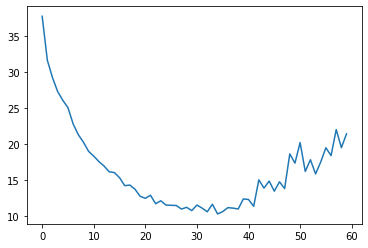

In [48]:
plt.plot(test_losses)

In [49]:
from torch.distributions.multivariate_normal import MultivariateNormal

def sample_multivariate(mu, cov):
    m = MultivariateNormal(mu, covariance_matrix=cov)
    return m.sample()

In [50]:
with torch.no_grad():
    sample = torch.randn(20000, latent_dim).to(device)
    mu, cov = model.decode(sample)
    sample = sample_multivariate(mu, cov)
print(sample)

tensor([[-0.6764, -1.0424,  0.0211,  ..., -1.2808,  0.5815, -0.0943],
        [-2.6450, -0.3996,  1.0904,  ...,  0.1192, -0.7074,  2.3275],
        [-0.4143, -0.3183, -1.1141,  ..., -0.6810, -0.3774,  1.6035],
        ...,
        [-0.8455, -0.4234,  0.5255,  ..., -1.8640, -1.0072,  0.5220],
        [ 0.2627,  0.1527,  0.1218,  ...,  0.1679,  0.2926, -0.5867],
        [ 0.6180, -0.2727,  0.2276,  ..., -0.3879, -0.7925,  0.5174]])


In [51]:
sample.shape
MIMIC_filtered = MIMIC_combined.drop(columns=['icustay_id', 'gender'])
resampled = pd.DataFrame(data=sample.numpy(), columns=MIMIC_combined_raw.columns[2:])*MIMIC_filtered.std() + MIMIC_filtered.mean()
resampled

,age,Weight_kg,paCO2_t0,paO2_t0,HCO3_t0,Arterial_pH_t0,Calcium_t0,Chloride_t0,DiaBP_t0,Glucose_t0,...,Chloride_t4,DiaBP_t4,Glucose_t4,MeanBP_t4,Potassium_t4,RR_t4,Temp_C_t4,Sodium_t4,SysBP_t4,HR_t4
0,19832.220710,56.520488,43.397174,51.944997,1729.415718,7.517713,76.585302,3159.346860,63.501776,1063.519404,...,3574.384835,70.274336,1703.173694,88.688110,146.730397,21.737989,36.006046,3007.807925,132.372648,84.364503
1,8043.275407,72.332296,56.603215,358.203004,1758.328225,7.205812,75.716207,3820.379982,59.422781,1170.431223,...,3646.726051,76.490856,1186.379585,83.249907,171.568732,22.617699,38.182504,3185.094602,105.229250,127.334150
2,21401.705509,74.330749,29.377657,356.371425,1204.968735,7.339074,87.370507,3550.899292,53.177272,929.509003,...,3638.535330,60.383731,1230.815734,82.085166,190.689681,15.034156,37.513179,3083.764158,112.178402,114.488872
3,21728.659453,74.346081,44.834890,222.943861,1287.660018,7.422787,93.088717,3739.748982,75.385568,1131.191580,...,3668.899524,73.333233,973.295123,80.023667,151.880864,19.351559,36.676789,3148.049160,109.715447,88.976854
4,29312.142506,100.615246,44.401754,78.079499,1529.264542,7.370290,119.029169,3834.884437,74.499421,2546.535326,...,3875.555760,64.318818,1428.176334,74.475163,152.029935,29.583925,36.259268,3254.422760,118.295671,97.906582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,15745.691007,75.412498,49.444537,111.017589,1433.754304,7.418414,73.216821,3741.376979,69.328599,1289.390112,...,3832.436173,81.394154,1218.012741,81.222205,167.267651,22.757246,37.650366,3341.492425,91.019801,86.895107
19996,17876.394755,91.128982,57.086296,210.482771,1545.664802,7.231915,80.925059,3446.091180,48.821702,2505.149711,...,3507.939395,21.624494,2833.680250,48.928166,182.650152,23.488133,34.975704,3077.281850,90.219556,80.967224
19997,18819.947145,71.745080,49.625674,79.173880,1497.090421,7.399587,83.158437,3366.959391,30.206155,1320.524165,...,3279.163436,26.803927,1254.628961,45.924422,186.230893,10.294552,36.961110,2933.946735,98.914179,95.299838
19998,25456.235242,85.915604,44.640352,79.724946,583.751169,7.315727,62.173456,3769.253671,70.832871,663.932357,...,3379.911117,40.907817,3557.452620,69.090113,134.688522,28.417608,36.432790,3191.262094,126.288904,75.629441


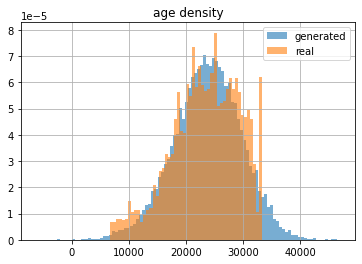

In [52]:
col_name = 'age'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==0, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

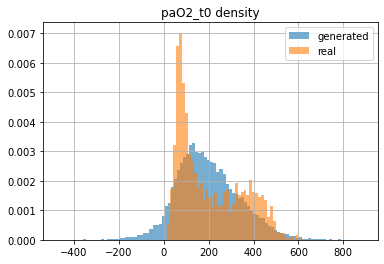

In [53]:
col_name = 'paO2_t0'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==0, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

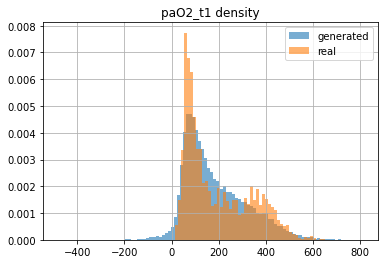

In [54]:
col_name = 'paO2_t1'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==0, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

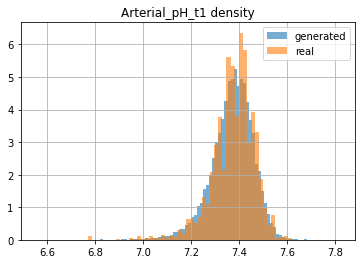

In [55]:
col_name = 'Arterial_pH_t1'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==0, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

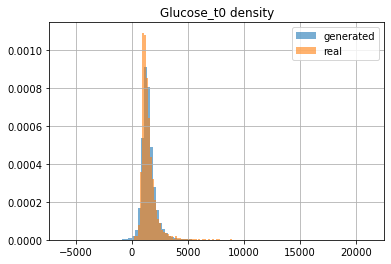

In [56]:
col_name = 'Glucose_t0'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==0, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

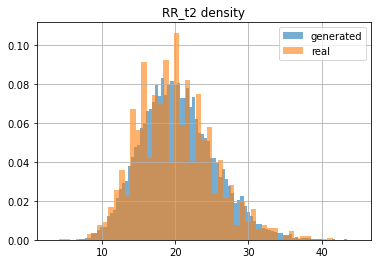

In [57]:
col_name = 'RR_t2'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==0, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

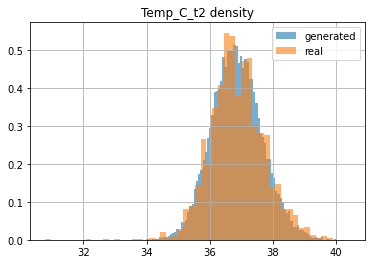

In [58]:
col_name = 'Temp_C_t2'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==0, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

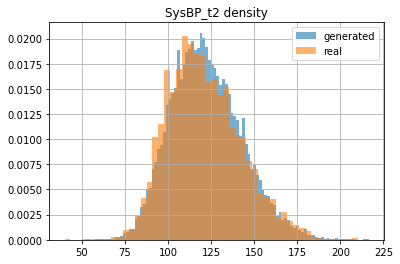

In [59]:
col_name = 'SysBP_t2'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==0, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

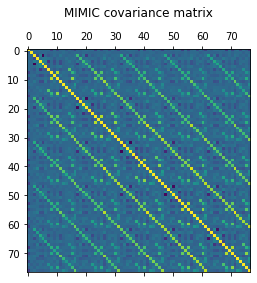

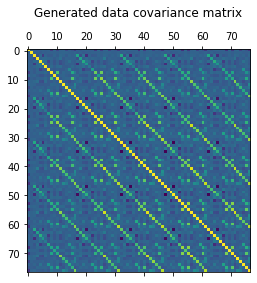

In [60]:
import matplotlib.pyplot as plt

plt.matshow(MIMIC_combined_raw[MIMIC_combined['gender']==0].drop(columns=['icustay_id', 'gender']).corr())
plt.title('MIMIC covariance matrix\n')
plt.matshow(resampled.corr())
plt.title('Generated data covariance matrix\n')
plt.show()

In [13]:
pulse_data_t0 = pulse_data[pulse_data['index']==1].reset_index(drop=True)
pulse_data_t1 = pulse_data[pulse_data['index']==2].reset_index(drop=True)
pulse_data_t2 = pulse_data[pulse_data['index']==3].reset_index(drop=True)

pulse_data_t0 = MIMICtable[MIMICtable['bloc']==2][['gender', 'age', 'Weight_kg', 'icustay_id', 'A']].merge(pulse_data_t0, on=['icustay_id'])
pulse_data_t1 = MIMICtable[MIMICtable['bloc']==3][['gender', 'age', 'Weight_kg', 'icustay_id', 'A']].merge(pulse_data_t1, on=['icustay_id'])
pulse_data_t2 = MIMICtable[MIMICtable['bloc']==4][['gender', 'age', 'Weight_kg', 'icustay_id', 'A']].merge(pulse_data_t2, on=['icustay_id'])


In [14]:
pulse_data.head()

,index,Albumin,paCO2,paO2,ArterialPressure (mmHg),HCO3,Arterial_pH,BUN,BloodVolume (mL),Calcium,...,RR,PaO2_FiO2,SimulationTime(s),Temp_C,Sodium,SysBP,WBC_count,id,time,icustay_id
0,0,36942.076357,40.766614,89.927432,116.205401,1589.280619,7.406174,12.954165,6432.049911,48.181075,...,18.633540,4.638695,0.0,33.203250,3328.440581,119.230483,7000.0,86855.0,6.607069e+09,86855
1,1,36524.917484,40.872763,90.052348,92.470480,1589.598103,7.405145,13.608056,6492.148657,53.043316,...,18.750000,4.633428,3600.0,33.879672,3319.123490,122.674910,7000.0,86855.0,6.607073e+09,86855
2,2,36069.948819,40.889780,90.176441,105.766357,1589.422211,7.404981,14.168092,6560.608547,57.671101,...,18.750000,4.633453,7200.0,32.973720,3311.273411,123.910096,7000.0,86855.0,6.607076e+09,86855
3,3,35344.795982,40.949980,90.585038,99.518088,1589.162254,7.404399,14.827684,6681.667603,61.641868,...,18.867925,4.635279,10800.0,33.382638,3311.388720,121.909499,7000.0,86855.0,6.607080e+09,86855
4,4,34739.622499,40.941064,90.624763,120.664434,1589.148171,7.404485,14.816667,6784.488523,65.534987,...,18.867925,4.635250,14400.0,33.415902,3280.588569,122.044169,7000.0,86855.0,6.607084e+09,86855


In [15]:
MIMICtable.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance,A
0,1,65537,7.139723e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.687500,363.888889,0.18,0.18,4020.493550,29.994183,7235.0,3605.0,-3184.512267,1
1,2,65537,7.139727e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.602564,430.555556,0.00,0.00,4050.487733,515.407667,10760.0,3525.0,-6194.104600,2
2,3,65537,7.139731e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.751456,402.222222,0.00,0.00,4565.895400,547.876700,14235.0,3475.0,-9121.227900,2
3,4,65537,7.139734e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.804762,275.000000,0.00,0.00,5113.772100,2097.144000,17630.0,3395.0,-10419.083900,2
4,5,65537,7.139738e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.804245,283.000000,0.00,0.00,7210.916100,519.833583,20785.0,3155.0,-13054.250317,2


# Supervised Learning of Actions - Logistic Regression


In [16]:
MIMICtable_filtered_t0.head()

,level_0,index,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,...,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance,A
0,0,0,1,65537,7.139723e+09,0.0,22799.404780,4.0,1.0,0.0,...,0.687500,363.888889,0.18,0.18,4020.49355,29.994183,7235.0,3605.0,-3184.512267,1
1,2,10,1,65544,7.056917e+09,0.0,24000.436400,3.0,0.0,0.0,...,0.770925,938.636364,0.00,0.00,11332.00000,0.000000,8210.0,4105.0,3122.000000,3
2,3,15,1,98314,4.762714e+09,0.0,23940.093773,4.0,0.0,1.0,...,0.906504,287.500000,0.00,0.00,0.00000,0.000000,14490.0,7245.0,-14490.000000,3
3,4,20,1,14,4.264269e+09,0.0,30946.970000,2.0,0.0,0.0,...,0.647399,577.499991,0.00,0.00,0.00000,80.000000,1263.0,599.0,-1183.000000,7
4,5,25,1,65553,7.142713e+09,0.0,19339.946505,2.0,1.0,0.0,...,0.783654,153.571429,0.00,0.00,1350.00000,400.000000,1625.0,780.0,125.000000,2


In [17]:
# #################   Convert training data and compute conversion factors    ######################
# logging.info('Processing raw data')
# # all 47 columns of interest
# colbin = ['gender']
# colnorm=['age','Weight_kg','GCS','HR','SysBP','MeanBP','DiaBP','RR','Temp_C','FiO2_1',\
#     'Potassium','Sodium','Chloride','Glucose','Magnesium','Calcium',\
#     'Hb','WBC_count','Platelets_count','PTT','PT','Arterial_pH','paO2','paCO2',\
#     'Arterial_BE','HCO3','Arterial_lactate','SOFA','SIRS','Shock_Index','PaO2_FiO2','cumulated_balance']
# # collog=['SpO2','BUN','Creatinine','SGOT','SGPT','Total_bili','INR','output_total','output_1hourly']


# MIMICraw = MIMIC_data_combined[['gender', 'age', f'{col_name}_t0']].copy()

# for col in MIMICraw:
#     if col in colbin:
#         MIMICraw[col] = MIMICraw[col] - 0.5
# #     elif col in colnorm:
#     else:
#         cmu = MIMICraw[col].mean()
#         csigma = MIMICraw[col].std()
#         MIMICraw[col] = (MIMICraw[col] - cmu)/csigma
# #     else:
# #         log_values = np.log(0.1 + MIMICraw[col])
# #         dmu = log_values.mean()
# #         dsigma = log_values.std()
# #         MIMICraw[col] = (log_values - dmu)/dsigma    
# logging.info('Raw data processed')


In [18]:
#################   Convert training data and compute conversion factors    ######################
logging.info('Processing raw data')
# all 47 columns of interest
colbin = ['gender']
colnorm=['age','Weight_kg','GCS','HR','SysBP','MeanBP','DiaBP','RR','Temp_C','FiO2_1',\
    'Potassium','Sodium','Chloride','Glucose','Magnesium','Calcium',\
    'Hb','WBC_count','Platelets_count','PTT','PT','Arterial_pH','paO2','paCO2',\
    'Arterial_BE','HCO3','Arterial_lactate','SOFA','SIRS','Shock_Index','PaO2_FiO2','cumulated_balance']
collog=['SpO2','BUN','Creatinine','SGOT','SGPT','Total_bili','INR','output_total','output_1hourly']


MIMICraw_t0 = MIMICtable_filtered_t0[x_columns].copy()

for col in MIMICraw_t0:
    if col in colbin:
        MIMICraw_t0[col] = MIMICraw_t0[col] - 0.5
    elif col in colnorm:
        cmu = MIMICraw_t0[col].mean()
        csigma = MIMICraw_t0[col].std()
        MIMICraw_t0[col] = (MIMICraw_t0[col] - cmu)/csigma
    else:
        log_values = np.log(0.1 + MIMICraw_t0[col])
        dmu = log_values.mean()
        dsigma = log_values.std()
        MIMICraw_t0[col] = (log_values - dmu)/dsigma    
logging.info('Raw data processed')


In [19]:
MIMICraw_t1 = MIMICtable_filtered_t1[x_columns].copy()

for col in MIMICraw_t1:
    if col in colbin:
        MIMICraw_t1[col] = MIMICraw_t1[col] - 0.5
    elif col in colnorm:
        cmu = MIMICraw_t1[col].mean()
        csigma = MIMICraw_t1[col].std()
        MIMICraw_t1[col] = (MIMICraw_t1[col] - cmu)/csigma
    else:
        log_values = np.log(0.1 + MIMICraw_t1[col])
        dmu = log_values.mean()
        dsigma = log_values.std()
        MIMICraw_t1[col] = (log_values - dmu)/dsigma    
logging.info('Raw data processed')


In [20]:
#################   Convert training data and compute conversion factors    ######################
logging.info('Processing raw data')
# all 47 columns of interest
colbin = ['gender']
colnorm=['age','Weight_kg','GCS','HR','SysBP','MeanBP','DiaBP','RR','Temp_C','FiO2_1',\
    'Potassium','Sodium','Chloride','Glucose','Magnesium','Calcium',\
    'Hb','WBC_count','Platelets_count','PTT','PT','Arterial_pH','paO2','paCO2',\
    'Arterial_BE','HCO3','Arterial_lactate','SOFA','SIRS','Shock_Index','PaO2_FiO2','cumulated_balance']
collog=['SpO2','BUN','Creatinine','SGOT','SGPT','Total_bili','INR','output_total','output_1hourly']

pulseraw_t0 = pulse_data_t0[x_columns].copy()

for col in pulseraw_t0:
    if col in colbin:
        pulseraw_t0[col] = pulseraw_t0[col] - 0.5
    elif col in colnorm:
        cmu = pulseraw_t0[col].mean()
        csigma = pulseraw_t0[col].std()
        pulseraw_t0[col] = (pulseraw_t0[col] - cmu)/csigma
logging.info('Raw data processed')


In [21]:
pulseraw_t1 = pulse_data_t1[x_columns].copy()

for col in pulseraw_t1:
    if col in colbin:
        pulseraw_t1[col] = pulseraw_t1[col] - 0.5
    elif col in colnorm:
        cmu = pulseraw_t1[col].mean()
        csigma = pulseraw_t1[col].std()
        pulseraw_t1[col] = (pulseraw_t1[col] - cmu)/csigma
logging.info('Raw data processed')

In [22]:
MIMICraw_t0.head()

,gender,age,Weight_kg,paCO2,paO2,HCO3,Arterial_pH,Calcium,Chloride,DiaBP,Glucose,MeanBP,Potassium,RR,Temp_C,Sodium,SysBP,HR
0,-0.5,-0.181005,1.008545,-0.253138,-0.530543,-1.187214,-0.295559,0.677169,-2.267751,-0.052501,-0.384950,0.064435,1.092684,-1.141790,-0.896077,-0.335581,-0.497062,-0.571733
1,-0.5,0.019513,-0.337459,0.070875,1.471908,0.709345,0.128633,-2.074709,0.113100,-0.690962,-0.278155,-0.631437,0.131543,0.964441,0.216938,0.047750,-0.429897,0.002577
2,-0.5,0.009438,-1.545203,-1.792198,-0.807477,-0.997558,2.143545,0.065641,-0.283708,1.594056,1.811031,1.356770,1.413064,1.605468,-0.460549,-0.910578,-0.004514,1.315287
3,-0.5,1.179266,-0.361858,0.718900,0.179546,-0.049279,-1.356039,-0.851652,1.382888,0.350737,-0.451698,0.071801,0.131543,-1.752292,0.120152,1.197744,-0.347805,-0.699358
4,-0.5,-0.758576,-0.496052,0.151878,-1.155421,2.985216,1.719353,-0.138202,-2.267751,-0.086104,-0.465047,-0.465753,0.932494,0.231839,-0.073416,-1.293910,-0.855279,-0.325600


In [77]:
from scipy import stats
males=MIMICraw_t0[MIMICraw_t0['gender']==-0.5].drop(columns=['gender'])
females=MIMICraw_t0[MIMICraw_t0['gender']==0.5].drop(columns=['gender'])

male_kernel = stats.gaussian_kde(dataset=males.values.T)
female_kernel = stats.gaussian_kde(dataset=females.values.T)

male_pop = int(len(males)/len(MIMICraw_t0)*10000)
female_pop = 10000 - male_pop
males_resampled = male_kernel.resample(size=male_pop)
females_resampled = female_kernel.resample(size=female_pop)

males_resampled = pd.DataFrame(data=males_resampled.T, columns=males.columns)
males_resampled['gender'] = -0.5

females_resampled = pd.DataFrame(data=females_resampled.T, columns=females.columns)
females_resampled['gender'] = -0.5

MIMICraw_resampled = pd.concat([males_resampled, females_resampled])
MIMICraw_resampled = MIMICraw_resampled[MIMICraw_t0.columns]
MIMICraw_resampled.head()

,gender,age,Weight_kg,paCO2,paO2,HCO3,Arterial_pH,Calcium,Chloride,DiaBP,Glucose,MeanBP,Potassium,RR,Temp_C,Sodium,SysBP,HR
0,-0.5,-0.227385,0.041677,1.091489,-0.893983,0.144963,-1.205827,-0.186702,1.305244,0.611818,-0.540835,0.605752,1.034563,-0.489857,1.148651,0.854596,-0.017132,1.168105
1,-0.5,-1.561320,-1.099388,0.224349,-1.030063,2.282970,0.208105,-0.354833,-1.632480,0.688055,0.882758,0.335755,-1.341765,1.686863,-0.295387,-0.175465,-0.161546,0.683425
2,-0.5,0.907427,0.544539,0.546386,-0.843256,2.139722,0.778085,0.373748,-1.311775,-0.792876,0.592057,-0.638225,-1.219944,2.264098,-2.321409,0.829014,-0.395367,-0.344263
3,-0.5,-0.888179,0.610737,-0.425061,0.039390,-0.975344,-0.055896,1.132361,0.962761,0.715518,0.541510,0.261897,-0.465675,-0.742384,0.162371,0.091881,0.237977,1.406083
4,-0.5,1.001753,0.547578,-0.362656,0.770458,0.375755,-1.215303,0.726712,0.758347,-1.701583,0.260728,0.333344,-0.514346,3.069816,-1.750175,-0.322968,-0.681962,0.889011


## Fitting models

In [78]:
from sklearn.linear_model import LogisticRegression
icuuniqueids = MIMICtable_filtered_t0['icustay_id'].unique()
modelsDf = pd.DataFrame()

logging.info('Fitting models')

for model in tqdm(range(nr_reps)):
    logging.info('Model: ' + str(model))
    grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
    crossval = 1
    trainidx = icuuniqueids[grp != crossval]
    testidx = icuuniqueids[grp == crossval]
    X = MIMICraw_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)]
    Xtestmimic = MIMICraw_t0[MIMICtable_filtered_t0['icustay_id'].isin(testidx)]
    Y = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'A']
    Ytest = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'A']
        
    clf = LogisticRegression(random_state=0, max_iter=100000).fit(X, Y)
    acc_train = clf.score(X, Y)
    acc_test = clf.score(Xtestmimic, Ytest)
    modelsDf = modelsDf.append({'model': model, 'regressor': clf, 'acc_train': acc_train, 'acc_test': acc_test}, ignore_index=True)
logging.info('Model fitting done!')

100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


In [79]:
clf.predict_proba(Xtestmimic)

array([[6.73576592e-03, 6.26721091e-02, 6.34713123e-01, ...,
        2.46946541e-03, 4.60213525e-03, 1.01336170e-03],
       [4.73586098e-04, 5.39671990e-02, 5.20380813e-01, ...,
        1.28120109e-04, 1.37239859e-04, 1.03693223e-04],
       [1.24085170e-02, 8.45709399e-02, 5.94144849e-01, ...,
        1.41336993e-02, 1.21956472e-02, 4.17732453e-03],
       ...,
       [1.55697950e-02, 6.74462874e-02, 5.03863455e-01, ...,
        4.26705940e-03, 2.84387452e-03, 2.08585988e-03],
       [4.78009735e-03, 7.89200650e-02, 4.10851378e-01, ...,
        3.41866539e-03, 2.32323508e-03, 3.47061981e-03],
       [2.95783038e-03, 4.35654903e-02, 5.97485844e-01, ...,
        2.08521648e-03, 2.75220804e-03, 1.05530756e-03]])

In [80]:
modelsDf

,acc_test,acc_train,model,regressor
0,0.519517,0.525061,0.0,"LogisticRegression(C=1.0, class_weight=None, d..."
1,0.527255,0.524535,1.0,"LogisticRegression(C=1.0, class_weight=None, d..."


# Fit $\pi(a_0\mid x_0)$ using Neural Net

In [81]:
import torch.utils.data as data_utils

class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_1_dim=10):
        super(PolicyNetwork, self).__init__()
        self.hid1 = torch.nn.Linear(input_dim, hidden_1_dim)
        self.outp = torch.nn.Linear(hidden_1_dim, output_dim)
        self.softmax = torch.nn.Softmax(dim=2)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.tanh = torch.nn.Tanh()

        torch.nn.init.xavier_uniform_(self.hid1.weight)
        torch.nn.init.zeros_(self.hid1.bias)
        torch.nn.init.xavier_uniform_(self.outp.weight)
        torch.nn.init.zeros_(self.outp.bias)

    def forward(self, x):
        z = self.tanh(self.hid1(x))
        z = self.outp(z)
        return z

In [82]:
icuuniqueids = MIMICtable_filtered_t0['icustay_id'].unique()
for model in tqdm(range(nr_reps)):
    grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
    crossval = 1
    trainidx = icuuniqueids[grp != crossval]
    testidx = icuuniqueids[grp == crossval]
    X = torch.FloatTensor(MIMICraw_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)].values)
    Xtestmimic = torch.FloatTensor(MIMICraw_t0[MIMICtable_filtered_t0['icustay_id'].isin(testidx)].values)
    Y = torch.tensor(MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'A'].values).to(torch.long)-1
    Ytest = torch.tensor(MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'A'].values).to(torch.long)-1
    train = data_utils.TensorDataset(X, Y)
    trainloader = torch.utils.data.DataLoader(train, batch_size=32)
    test = data_utils.TensorDataset(Xtestmimic, Ytest)
    testloader = torch.utils.data.DataLoader(test, batch_size=32)

    loss_func = torch.nn.CrossEntropyLoss()
    policy = PolicyNetwork(input_dim=len(MIMICraw_t0.columns), output_dim=25)
    optimizer = torch.optim.SGD(policy.parameters(), lr=0.001)    
    for epoch in range(100):
        for data, label in trainloader:
            prediction = policy(data)     # input x and predict based on x
            loss = loss_func(prediction, label)     # must be (1. nn output, 2. target)
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
    torch.save(policy.state_dict(), f'{models_dir}/policy_{model}')
    

100%|██████████| 2/2 [00:09<00:00,  4.84s/it]


In [83]:
icuuniqueids = MIMICtable_filtered_t0['icustay_id'].unique()
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]
X = torch.FloatTensor(MIMICraw_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)].values)
Xtestmimic = torch.FloatTensor(MIMICraw_t0[MIMICtable_filtered_t0['icustay_id'].isin(testidx)].values)
Y = torch.tensor(MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'A'].values).to(torch.long)-1
Ytest = torch.tensor(MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'A'].values).to(torch.long)-1
train = data_utils.TensorDataset(X, Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(Xtestmimic, Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.CrossEntropyLoss()
policy = PolicyNetwork(input_dim=len(MIMICraw_t0.columns), output_dim=25)
optimizer = torch.optim.SGD(policy.parameters(), lr=0.001)

In [84]:
losses = []

for epoch in tqdm(range(200)):
    for data, label in trainloader:
        prediction = policy(data)     # input x and predict based on x
        loss = loss_func(prediction, label)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            test_loss = 0
            for test_data, test_label in testloader:
                test_loss += loss_func(policy(test_data), test_label)
            losses.append(test_loss.item()/len(testloader))

100%|██████████| 200/200 [00:09<00:00, 20.00it/s]


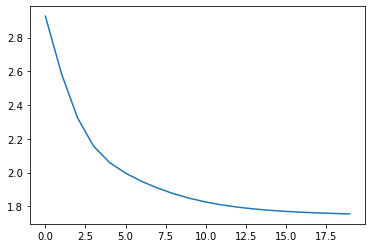

In [85]:
plt.plot(losses)

In [86]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    outputs = policy(Xtestmimic)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
#     predicted = Categorical(softmax(outputs)).sample()
    total += Xtestmimic.size(0)
    correct += (predicted == Ytest).sum().item()

print('Accuracy of the policy network: %d %%' % (
    100 * correct / total))

Accuracy of the policy network: 50 %


# Predicting actions for the augmented data

In [87]:
from torch.distributions import Categorical
softmax = torch.nn.Softmax(dim=1)
outputs = softmax(policy(torch.FloatTensor(MIMICraw_resampled[x_columns].values)))
# outputs

m = Categorical(outputs)
action = m.sample()
(action!=1).sum()
MIMICraw_resampled['A'] = action.numpy()+1

# Regressing $\mathbb{E}[Y^{obs}\mid x,a]$

In [88]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data


class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [89]:
net = Net(n_feature=len(MIMICraw_t0.columns)+1, n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, weight_decay=0.1)
loss_func = torch.nn.MSELoss()

In [90]:
for model in tqdm(range(nr_reps)):
    grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
    crossval = 1
    trainidx = icuuniqueids[grp != crossval]
    testidx = icuuniqueids[grp == crossval]
    X = torch.FloatTensor(MIMICraw_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)].values)
    A = (torch.tensor(MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'A'].values).to(torch.long)-1)/24
    Xtestmimic = torch.FloatTensor(MIMICraw_t0[MIMICtable_filtered_t0['icustay_id'].isin(testidx)].values)
    Atest = (torch.tensor(MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'A'].values).to(torch.long)-1)/24
    ptid = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'icustay_id']
    ptidtestmimic = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'icustay_id']
    Y = torch.FloatTensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), f'{col_name}'].values).unsqueeze(dim=1)
    Ytest = torch.FloatTensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), f'{col_name}'].values).unsqueeze(dim=1)
    Y = (Y - MIMICtable[col_name].mean())/MIMICtable[col_name].std()
    Ytest = (Ytest - MIMICtable[col_name].mean())/MIMICtable[col_name].std()
    train = data_utils.TensorDataset(torch.column_stack((X, A)), Y)
    trainloader = torch.utils.data.DataLoader(train, batch_size=32)
    test = data_utils.TensorDataset(torch.column_stack((Xtestmimic, Atest)), Ytest)
    testloader = torch.utils.data.DataLoader(test, batch_size=32)

    net = Net(n_feature=len(MIMICraw_t0.columns)+1, n_hidden=10, n_output=1)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, weight_decay=0.1)
    loss_func = torch.nn.MSELoss()
    for epoch in range(200):
        for X, Y in trainloader:
            prediction = net(X)     # input x and predict based on x

            loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
    
    torch.save(net.state_dict(), f'{models_dir}/yobs_{model}')

100%|██████████| 2/2 [00:18<00:00,  9.42s/it]


In [91]:
import torch.utils.data as data_utils

grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]
X = torch.FloatTensor(MIMICraw_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)].values)
A = (torch.tensor(MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'A'].values).to(torch.long)-1)/24
Xtestmimic = torch.FloatTensor(MIMICraw_t0[MIMICtable_filtered_t0['icustay_id'].isin(testidx)].values)
Atest = (torch.tensor(MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'A'].values).to(torch.long)-1)/24
ptid = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'icustay_id']
ptidtestmimic = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'icustay_id']
Y = torch.FloatTensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), f'{col_name}'].values).unsqueeze(dim=1)
Ytest = torch.FloatTensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), f'{col_name}'].values).unsqueeze(dim=1)
Y = (Y - MIMICtable[col_name].mean())/MIMICtable[col_name].std()
Ytest = (Ytest - MIMICtable[col_name].mean())/MIMICtable[col_name].std()
train = data_utils.TensorDataset(torch.column_stack((X, A)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtestmimic, Atest)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

net = Net(n_feature=len(MIMICraw_t0.columns)+1, n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, weight_decay=0.1)
loss_func = torch.nn.MSELoss()

In [92]:
# train the network
losses = []
for epoch in tqdm(range(200)):
    for X, Y in trainloader:
        prediction = net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())


100%|██████████| 200/200 [00:10<00:00, 18.49it/s]


0.4557711184024811

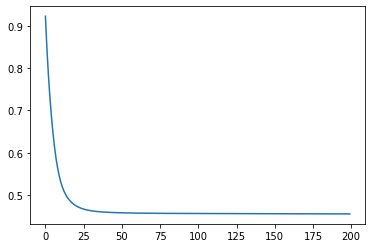

In [93]:
import matplotlib.pyplot as plt
plt.plot(losses)
losses[-1]

In [94]:
action = 1
row = 2
action_tensor = torch.FloatTensor(((action-1)/24,))
print(f'{col_name} val at t=0', Xtestmimic[row,x_columns.index(col_name)]*MIMICtable[col_name].std() + MIMICtable[col_name].mean())
print(f'{col_name} val at t=1', net(torch.cat((Xtestmimic[row,:], action_tensor)))*MIMICtable[col_name].std() + MIMICtable[col_name].mean())


HR val at t=0 tensor(99.9075)
HR val at t=1 tensor([97.3827], grad_fn=<AddBackward0>)


# Augmenting patient values at time 1

In [95]:
models_dir = "/data/localhost/taufiq/manski_bounds_bootstrap/"
static_cols = ['gender', 'age', 'Weight_kg']
MIMICraw_resampled_t1 = MIMICraw_resampled[static_cols].copy()
i=0
# x_columns
for col_name in tqdm(x_columns):
    if col_name not in static_cols:                
        yobs_model = Net(n_feature=MIMICraw_t0.shape[1]+1, n_hidden=10, n_output=1)
        yobs_model.load_state_dict(torch.load(f'{models_dir}/yobs_{col_name}_{i}'))
        yobs_model.eval()
        with torch.no_grad():
            X_resampled = torch.FloatTensor(MIMICraw_resampled.drop(columns=['A']).values)
            A_resampled = (torch.FloatTensor(MIMICraw_resampled['A'].values)-1)/24
            y = yobs_model(torch.column_stack((X_resampled, A_resampled)))
            MIMICraw_resampled_t1[col_name] = y.numpy()



100%|██████████| 18/18 [00:00<00:00, 907.60it/s]


In [96]:
MIMICraw_resampled_t1.head()

,gender,age,Weight_kg,paCO2,paO2,HCO3,Arterial_pH,Calcium,Chloride,DiaBP,Glucose,MeanBP,Potassium,RR,Temp_C,Sodium,SysBP,HR
0,-0.5,-0.227385,0.041677,0.594050,-0.281194,0.024615,-0.690573,-0.039004,0.651407,0.518146,-0.290032,0.369115,0.996962,-0.159710,0.581757,0.515691,0.099839,0.934715
1,-0.5,-1.561320,-1.099388,0.229529,-0.488388,1.008575,0.087236,-0.171043,-0.779157,0.692078,0.419671,0.385285,-1.173494,1.163643,-0.077044,-0.052106,-0.099260,0.729356
2,-0.5,0.907427,0.544539,0.401895,-0.363626,1.059618,0.407039,0.216479,-0.627830,-0.432824,0.339273,-0.395542,-1.046500,1.420170,-1.038844,0.389609,-0.246952,-0.229466
3,-0.5,-0.888179,0.610737,-0.257847,0.191340,-0.443214,-0.075627,0.410710,0.465746,0.598441,0.264681,0.389372,-0.236505,-0.416256,0.167789,0.183759,0.193808,1.077253
4,-0.5,1.001753,0.547578,-0.195535,0.522932,0.067859,-0.517809,0.237475,0.229882,-0.706982,0.250616,-0.328230,-0.260257,1.800928,-0.739761,-0.054487,-0.256846,0.651850


# Fitting $\pi(a_1 \mid x_0,a_0,x_1)$

In [97]:
icuuniqueids = MIMICtable_filtered_t0['icustay_id'].unique()
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]
X0 = torch.FloatTensor(MIMICraw_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)].values)
Xtest0 = torch.FloatTensor(MIMICraw_t0[MIMICtable_filtered_t0['icustay_id'].isin(testidx)].values)
X1 = torch.FloatTensor(MIMICraw_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)].values)
Xtest1 = torch.FloatTensor(MIMICraw_t1[MIMICtable_filtered_t0['icustay_id'].isin(testidx)].values)
A0 = (torch.FloatTensor(MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'A'].values)-1)/24
Atest0 = (torch.FloatTensor(MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'A'].values)-1)/24

Y = torch.tensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'A'].values).to(torch.long)-1
Ytest = torch.tensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'A'].values).to(torch.long)-1
train = data_utils.TensorDataset(torch.column_stack((X0,X1,A0)), Y)
# train = data_utils.TensorDataset(X0, (A0*24).to(torch.long))
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
# test = data_utils.TensorDataset(Xtest0, (Atest0*24).to(torch.long))
test = data_utils.TensorDataset(torch.column_stack((Xtest0, Xtest1, Atest0)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.CrossEntropyLoss()
# policy = PolicyNetwork(input_dim=len(MIMICraw_t1.columns), output_dim=25)
policy_t1 = PolicyNetwork(input_dim=len(MIMICraw_t0.columns) + len(MIMICraw_t1.columns) + 1, hidden_1_dim=30, output_dim=25)
optimizer = torch.optim.SGD(policy_t1.parameters(), lr=0.005)

In [98]:
losses = []

for epoch in tqdm(range(400)):
    for data, label in trainloader:
        prediction = policy_t1(data)     # input x and predict based on x
        loss = loss_func(prediction, label)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            test_loss = 0
            for test_data, test_label in testloader:
                test_loss += loss_func(policy_t1(test_data), test_label)
            losses.append(test_loss.item()/len(testloader))

100%|██████████| 400/400 [00:19<00:00, 20.25it/s]


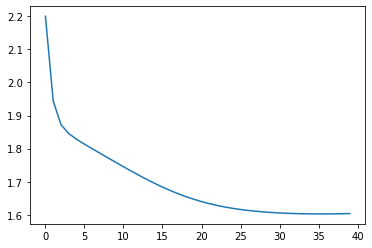

In [99]:
plt.plot(losses)

In [100]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    outputs = policy_t1(torch.column_stack((Xtest0, Xtest1, Atest0)))
#     outputs = policy(Xtest0)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
#     predicted = Categorical(softmax(outputs)).sample()
    total += Xtest0.size(0)
    correct += (predicted == Ytest).sum().item()

print('Accuracy of the policy network: %d %%' % (
    100 * correct / total))

Accuracy of the policy network: 50 %


# Augmenting patient data with $A_1$

In [101]:
with torch.no_grad():
    X0 = torch.FloatTensor(MIMICraw_resampled[x_columns].values)
    X1 = torch.FloatTensor(MIMICraw_resampled_t1[x_columns].values)
    A0 = torch.FloatTensor(MIMICraw_resampled['A'].values)
    inp = torch.column_stack((X0, X1, A0))
    outputs = policy_t1(inp)
#     predicted = Categorical(softmax(outputs)).sample()
    _, predicted = torch.max(outputs.data, 1)

MIMICraw_resampled_t1['A'] = predicted.numpy()+1

In [112]:
(MIMICraw_resampled_t1['A']==25).sum()

7702

In [110]:
(MIMICtable_filtered_t1['A']==25).sum()

32

# Regressing $\mathbb{E}[Y^{min}\mid x,a]$

In [22]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data


class QuantileNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(QuantileNet, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [120]:
class PinballLoss():
    def __init__(self, quantile=0.10, reduction='none'):
        self.quantile = quantile
        assert 0 < self.quantile
        assert self.quantile < 1
        self.reduction = reduction

    def __call__(self, output, target):
        assert output.shape == target.shape
        loss = torch.zeros_like(target, dtype=torch.float)
        error = output - target
        smaller_index = error < 0
        bigger_index = 0 < error
        loss[smaller_index] = self.quantile * (abs(error)[smaller_index])
        loss[bigger_index] = (1-self.quantile) * (abs(error)[bigger_index])

        if self.reduction == 'sum':
            loss = loss.sum()
        if self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [121]:
for model in tqdm(range(nr_reps)):
    grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
    crossval = 1
    trainidx = icuuniqueids[grp != crossval]
    testidx = icuuniqueids[grp == crossval]
    X = torch.FloatTensor(MIMICraw_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)].values)
    Xtestmimic = torch.FloatTensor(MIMICraw_t0[MIMICtable_filtered_t0['icustay_id'].isin(testidx)].values)
    ptid = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'icustay_id']
    ptidtestmimic = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'icustay_id']
    Y = torch.FloatTensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), f'{col_name}'].values).unsqueeze(dim=1)
    Ytest = torch.FloatTensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), f'{col_name}'].values).unsqueeze(dim=1)

    Y = (Y - MIMICtable[col_name].mean())/MIMICtable[col_name].std()
    Ytest = (Ytest - MIMICtable[col_name].mean())/MIMICtable[col_name].std()

    train = data_utils.TensorDataset(X, Y)
    trainloader = torch.utils.data.DataLoader(train, batch_size=32)
    test = data_utils.TensorDataset(Xtestmimic, Ytest)
    testloader = torch.utils.data.DataLoader(test, batch_size=32)

    quantile_net = QuantileNet(n_feature=len(MIMICraw_t0.columns), n_hidden=10, n_output=1)
    optimizer = torch.optim.SGD(quantile_net.parameters(), lr=0.001)
    loss_func = PinballLoss(quantile=0.001, reduction='mean')
    for epoch in range(200):
        for X, Y in trainloader:
            prediction = quantile_net(X)     # input x and predict based on x

            loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
    
    torch.save(quantile_net.state_dict(), f'{models_dir}/ymin_{model}')

100%|██████████| 2/2 [00:27<00:00, 13.58s/it]


In [122]:
quantile_net = QuantileNet(n_feature=len(MIMICraw_t0.columns), n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(quantile_net.parameters(), lr=0.001)
loss_func = PinballLoss(quantile=0.001, reduction='mean')

In [123]:
# train the network
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]
X = torch.FloatTensor(MIMICraw_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)].values)
Xtestmimic = torch.FloatTensor(MIMICraw_t0[MIMICtable_filtered_t0['icustay_id'].isin(testidx)].values)
ptid = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'icustay_id']
ptidtestmimic = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'icustay_id']
Y = torch.FloatTensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), f'{col_name}'].values).unsqueeze(dim=1)
Ytest = torch.FloatTensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), f'{col_name}'].values).unsqueeze(dim=1)

Y = (Y - MIMICtable[col_name].mean())/MIMICtable[col_name].std()
Ytest = (Ytest - MIMICtable[col_name].mean())/MIMICtable[col_name].std()

train = data_utils.TensorDataset(X, Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(Xtestmimic, Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

quantile_net = QuantileNet(n_feature=len(MIMICraw_t0.columns), n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(quantile_net.parameters(), lr=0.001)
loss_func = PinballLoss(quantile=0.001, reduction='mean')    

# train the network
losses = []
for epoch in tqdm(range(200)):
    for X, Y in trainloader:
        prediction = quantile_net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(quantile_net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())


100%|██████████| 200/200 [00:15<00:00, 12.99it/s]


0.009511603973805904

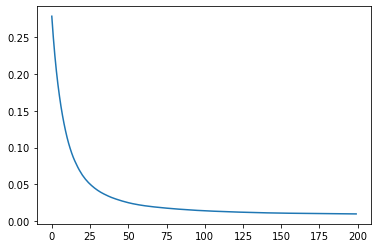

In [124]:
plt.plot(losses)
losses[-1]

In [125]:
action = 1
row = 1
action_tensor = torch.FloatTensor(((action-1)/24,))
print(f'{col_name} val at t=0', Xtestmimic[row,x_columns.index(col_name)]*MIMICtable[col_name].std() + MIMICtable[col_name].mean())
print(f'{col_name} min val at t=1', quantile_net(Xtestmimic[row,:])*MIMICtable[col_name].std() + MIMICtable[col_name].mean())

Calcium val at t=0 tensor(76.2175)
Calcium min val at t=1 tensor([59.4485], grad_fn=<AddBackward0>)


In [126]:
MIMICtable[col_name].median()

84.0

# Regressing $\mathbb{E}[Y^{max}\mid x,a]$

In [127]:
for model in tqdm(range(nr_reps)):
    grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
    crossval = 1
    trainidx = icuuniqueids[grp != crossval]
    testidx = icuuniqueids[grp == crossval]
    X = torch.FloatTensor(MIMICraw_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)].values)
    Xtestmimic = torch.FloatTensor(MIMICraw_t0[MIMICtable_filtered_t0['icustay_id'].isin(testidx)].values)
    ptid = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'icustay_id']
    ptidtestmimic = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'icustay_id']
    Y = torch.FloatTensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), f'{col_name}'].values).unsqueeze(dim=1)
    Ytest = torch.FloatTensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), f'{col_name}'].values).unsqueeze(dim=1)

    Y = (Y - MIMICtable[col_name].mean())/MIMICtable[col_name].std()
    Ytest = (Ytest - MIMICtable[col_name].mean())/MIMICtable[col_name].std()

    train = data_utils.TensorDataset(X, Y)
    trainloader = torch.utils.data.DataLoader(train, batch_size=32)
    test = data_utils.TensorDataset(Xtestmimic, Ytest)
    testloader = torch.utils.data.DataLoader(test, batch_size=32)

    quantile_net = QuantileNet(n_feature=len(MIMICraw_t0.columns), n_hidden=10, n_output=1)
    optimizer = torch.optim.SGD(quantile_net.parameters(), lr=0.001)
    loss_func = PinballLoss(quantile=0.999, reduction='mean')
    for epoch in range(200):
        for X, Y in trainloader:
            prediction = quantile_net(X)     # input x and predict based on x

            loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
    
    torch.save(quantile_net.state_dict(), f'{models_dir}/ymax_{model}')

100%|██████████| 2/2 [00:27<00:00, 13.94s/it]


In [128]:
quantile_net = QuantileNet(n_feature=len(MIMICraw_t0.columns), n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(quantile_net.parameters(), lr=0.001)
loss_func = PinballLoss(quantile=0.999, reduction='mean')

In [129]:
# train the network
losses = []
for epoch in tqdm(range(200)):
    for X, Y in trainloader:
        prediction = quantile_net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(quantile_net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())

100%|██████████| 200/200 [00:15<00:00, 12.64it/s]


0.01057497225701809

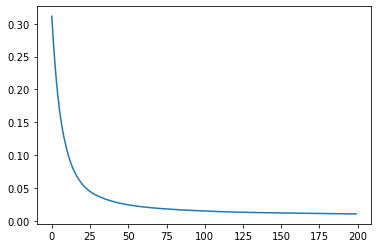

In [130]:
plt.plot(losses)
losses[-1]

In [131]:
action = 1
row = 3
action_tensor = torch.FloatTensor(((action-1)/24,))
print(f'{col_name} val at t=0', Xtestmimic[row,x_columns.index(col_name)]*MIMICtable[col_name].std() + MIMICtable[col_name].mean())
print(f'{col_name} max val at t=1', quantile_net(Xtestmimic[row,:])*MIMICtable[col_name].std() + MIMICtable[col_name].mean())

Calcium val at t=0 tensor(84.8186)
Calcium max val at t=1 tensor([111.2641], grad_fn=<AddBackward0>)


# Regressing $\mathbb{E}[Y^{sim}(a)\mid x]$

In [132]:
for model in tqdm(range(nr_reps)):
    icuuniqueids = pulse_data['icustay_id'].unique()
    grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
    crossval = 1
    trainidx = icuuniqueids[grp != crossval]
    testidx = icuuniqueids[grp == crossval]
    X = torch.FloatTensor(pulseraw_t0.loc[pulse_data_t0['icustay_id'].isin(trainidx)].values)
    Xtestmimic = torch.FloatTensor(pulseraw_t0[pulse_data_t0['icustay_id'].isin(testidx)].values)
    A = (torch.tensor(actionbloc.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'action_bloc'].values).to(torch.long)-1)/24
    Atest = (torch.tensor(actionbloc.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'action_bloc'].values).to(torch.long)-1)/24
    Y = torch.FloatTensor(pulse_data_t1.loc[pulse_data_t1['icustay_id'].isin(trainidx), f'{col_name}'].values).unsqueeze(dim=1)
    Ytest = torch.FloatTensor(pulse_data_t1.loc[pulse_data_t1['icustay_id'].isin(testidx), f'{col_name}'].values).unsqueeze(dim=1)
    Y = (Y - MIMICtable[col_name].mean())/MIMICtable[col_name].std()
    Ytest = (Ytest - MIMICtable[col_name].mean())/MIMICtable[col_name].std()

    train = data_utils.TensorDataset(torch.column_stack((X, A)), Y)
    trainloader = torch.utils.data.DataLoader(train, batch_size=32)
    test = data_utils.TensorDataset(torch.column_stack((Xtestmimic, Atest)), Ytest)
    testloader = torch.utils.data.DataLoader(test, batch_size=32)
    
    net = Net(n_feature=len(pulseraw_t0.columns) + 1, n_hidden=10, n_output=1)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, weight_decay=0.1)
    loss_func = torch.nn.MSELoss()

    for epoch in range(200):
        for X, Y in trainloader:
            prediction = net(X)     # input x and predict based on x

            loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
    
    torch.save(net.state_dict(), f'{models_dir}/ysim_{model}')

100%|██████████| 2/2 [00:15<00:00,  7.76s/it]


In [17]:
print('pulseraw_t0 columns:', len(pulseraw_t0.columns))
print('MIMICraw_t0 columns:', len(MIMICraw_t0.columns))

Pulseraw columns: 19
MIMICraw columns: 19


In [20]:
net = Net(n_feature=len(pulseraw_t0.columns) + 1, n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, weight_decay=0.1)
loss_func = torch.nn.MSELoss()

In [24]:
icuuniqueids = pulse_data['icustay_id'].unique()
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]
X = torch.FloatTensor(pulseraw_t0.loc[pulse_data_t0['icustay_id'].isin(trainidx)].values)
Xtestmimic = torch.FloatTensor(pulseraw_t0[pulse_data_t0['icustay_id'].isin(testidx)].values)
A = (torch.tensor(actionbloc.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'action_bloc'].values).to(torch.long)-1)/24
Atest = (torch.tensor(actionbloc.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'action_bloc'].values).to(torch.long)-1)/24
Y = torch.FloatTensor(pulse_data_t1.loc[pulse_data_t1['icustay_id'].isin(trainidx), f'{col_name}'].values).unsqueeze(dim=1)
Ytest = torch.FloatTensor(pulse_data_t1.loc[pulse_data_t1['icustay_id'].isin(testidx), f'{col_name}'].values).unsqueeze(dim=1)
Y = (Y - MIMICtable[col_name].mean())/MIMICtable[col_name].std()
Ytest = (Ytest - MIMICtable[col_name].mean())/MIMICtable[col_name].std()

train = data_utils.TensorDataset(torch.column_stack((X, A)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtestmimic, Atest)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)


In [25]:
losses = []
for epoch in tqdm(range(200)):
    for X, Y in trainloader:
        prediction = net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())


100%|██████████| 200/200 [00:08<00:00, 24.26it/s]


5.211307048797607

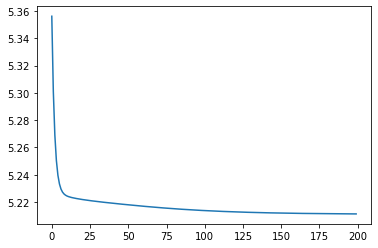

In [26]:
import matplotlib.pyplot as plt
plt.plot(losses)
losses[-1]

In [30]:
action = 1
row = 1
action_tensor = torch.FloatTensor(((action-1)/24,))
print(f'{col_name} val at t=0', Xtestmimic[row,x_columns.index(col_name)]*MIMICtable[col_name].std() + MIMICtable[col_name].mean())
print(f'{col_name} val at t=1', net(torch.cat((Xtestmimic[row,:], action_tensor)))*MIMICtable[col_name].std() + MIMICtable[col_name].mean())

paCO2 val at t=0 tensor(50.4456)
paCO2 val at t=1 tensor([40.0943], grad_fn=<AddBackward0>)


# Computing scores for simulated outcomes using saved models

In [139]:
def compute_score(gender, age, col_v, action, col_name, models_dir):
    softmax = torch.nn.Softmax(dim=0)
    gender = gender - 0.5
    age_normalized_sim = (age - pulse_data_combined['age'].mean())/pulse_data_combined['age'].std()
    col_normalized_sim = (col_v - pulse_data_t0[f'{col_name}'].mean())/pulse_data_t0[f'{col_name}'].std()
    sim_input = torch.FloatTensor((gender, age_normalized_sim, col_normalized_sim))
    age_normalized_obs = (age - MIMIC_data_combined['age'].mean())/MIMIC_data_combined['age'].std()
    col_normalized_obs = (col_v - MIMICtable_filtered_t0[f'{col_name}'].mean())/MIMICtable_filtered_t0[f'{col_name}'].std()
    obs_input = torch.FloatTensor((gender, age_normalized_obs, col_normalized_obs))
    action_tensor = torch.FloatTensor(((action-1)/24,))
    p = 0
    for i in range(nr_reps):
        yobs_model = Net(n_feature=4, n_hidden=10, n_output=1)
        yobs_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/yobs_{i}'))
        yobs_model.eval()
        ymax_model = Net(n_feature=3, n_hidden=10, n_output=1)
        ymax_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/ymax_{i}'))
        ymax_model.eval()
        ymin_model = Net(n_feature=3, n_hidden=10, n_output=1)
        ymin_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/ymin_{i}'))
        ymin_model.eval()
        ysim_model = Net(n_feature=4, n_hidden=10, n_output=1)
        ysim_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/ysim_{i}'))
        ysim_model.eval()
        policy = PolicyNetwork(input_dim=3, output_dim=25)
        policy.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/policy_{i}'))
        policy.eval()
        prob = softmax(policy(obs_input))[action-1]
        lb = prob*yobs_model(torch.cat((obs_input, action_tensor))) + (1-prob)*(ymin_model(obs_input))
        ub = prob*yobs_model(torch.cat((obs_input, action_tensor))) + (1-prob)*(ymax_model(obs_input))
        sim = ysim_model(torch.cat((sim_input, action_tensor)))
        p += int(((lb<=sim)&(sim<=ub)).item())
    p = p/nr_reps
    return p    

In [141]:
models_dir = "/data/localhost/taufiq/manski_bounds"
col_name = 'Temp_C'
compute_score(0, 65, 31, 0, col_name, models_dir)

In [ ]:
pulse_data_t0.head()

In [ ]:
ages = range(18,66)
scores = []
for age in tqdm(ages):
    score = compute_score(0, age, 32, 2)
    scores.append(score)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ages, scores)

In [ ]:
temps = range(29,35)
scores = []
for temp in tqdm(temps):
    score = compute_score(0, 40, temp, 1)
    scores.append(score)

In [ ]:
plt.plot(temps, scores)

In [ ]:
ages = np.linspace(18,65, num=65-18 + 1)
temps = np.linspace(29,36, num=(36-29)*5 + 1)
df = pd.DataFrame()
for age in tqdm(ages):
    for temp in temps:
        score = compute_score(0, age, temp, 2)
        df = df.append({'age': age, 'temp': temp, 'score': score}, ignore_index=True)

In [ ]:
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter

fig, axs = plt.subplots(1, 1, figsize=(15,12))
df_pivot = df.pivot_table(index="temp", columns="age", values="score", aggfunc=np.max)
df_pivot_smooth = gaussian_filter(df_pivot, sigma=0.1)
sns.heatmap(df_pivot_smooth, vmax=df_pivot.values.max(), xticklabels=ages, yticklabels=temps, vmin=df_pivot.values.min(), ax=axs)
plt.show()

In [ ]:
MIMICtable_filtered_t0['HR']

In [ ]:
pulse_data_t0['HR']